In [3]:
import torch
import json
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import ml_collections
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from data import MNISTSet, ShapeNet15kPointClouds, collate_fn
from torch.utils.data import DataLoader
from model import SetFlowModule
from config import create_config
from flow_matching.path.scheduler import CondOTScheduler, CosineScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from tqdm import tqdm

In [4]:
dataset = ShapeNet15kPointClouds(categories=['airplane'], split='train')

Total number of data:2832
Min number of points: (train)10000 (test)2048
Done!


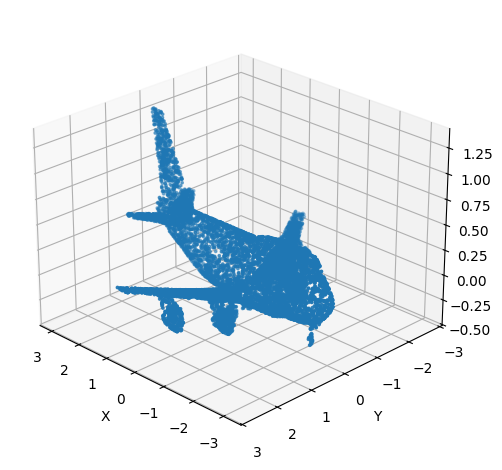

In [5]:
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
batch = next(iter(dataloader))
x_1, mask = batch["set"], batch["set_mask"]

x, y, z = x_1[0].T
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z, x, y, s=3)          # s = marker size
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

# optional cosmetics
ax.view_init(elev=25, azim=135)   # camera angle
plt.tight_layout()
plt.show()

In [30]:
# ckpt_path = "weights/shapenet-20250506-212844/checkpoint-epoch=28-train_loss=3.726551.ckpt"
ckpt_path = "weights/shapenet-mf-vfm/checkpoint-epoch=28-train_loss=6360.756348.ckpt"

with open(os.path.join(
        os.path.join(os.path.join(*ckpt_path.split("/")[:2])), "config.json"), 
        "r"
    ) as f:
        config_dict = json.load(f)
config = ml_collections.ConfigDict(config_dict)

mf_vfm_model = SetFlowModule.load_from_checkpoint(
    config=config,
    strict=False,
    checkpoint_path=ckpt_path
).to("cuda:3")

In [7]:
# out = mf_vfm_model.reconstruct(x_1.to("cuda:3"), 10000, timesteps=200, attn_mask=~mask.to("cuda:3"), mode="cfm")
# out = mf_vfm_model.reconstruct(x_1.to("cuda:3"), 10000, timesteps=200, attn_mask=~mask.to("cuda:3"), mode="vfm")
coords = out[0].detach().cpu().numpy()

NameError: name 'out' is not defined

In [8]:
x, y, z = coords.T
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z, x, y, s=3)          # s = marker size
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

# optional cosmetics
ax.view_init(elev=25, azim=135)   # camera angle
plt.tight_layout()
plt.show()

NameError: name 'coords' is not defined

In [9]:
test_data = []

for _ in range(50):
    dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
    batch = next(iter(dataloader))
    x_1, mask = batch["set"], batch["set_mask"]
    test_data.append((x_1, mask))

In [10]:
cfm_outputs = []
for x_1, mask in tqdm(test_data):
    out = mf_vfm_model.reconstruct(x_1.to("cuda:3"), 10000, timesteps=200, attn_mask=~mask.to("cuda:3"), mode="cfm")
    coords = out[0].detach().cpu().numpy()
    cfm_outputs.append(coords)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


In [36]:
vfm_outputs = []
for x_1, mask in tqdm(test_data):
    out = mf_vfm_model.reconstruct(x_1.to("cuda:3"), 10000, timesteps=200, attn_mask=~mask.to("cuda:3"), mode="vfm")
    coords = out[0].detach().cpu().numpy()
    vfm_outputs.append(coords)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:49<00:00,  3.39s/it]


In [11]:
import numpy as np
from scipy.spatial import cKDTree, distance_matrix
from scipy.optimize import linear_sum_assignment

# ---------- low-level distances ------------------------------------------------
def chamfer_distance(P: np.ndarray, Q: np.ndarray) -> float:
    """
    Symmetric Chamfer distance (squared ℓ2) between two N×3 point clouds.
    """
    # P,Q shape: [N,3]
    tree_P, tree_Q = cKDTree(P), cKDTree(Q)
    dPQ, _ = tree_P.query(Q)            # for every q ∈ Q find nearest p ∈ P
    dQP, _ = tree_Q.query(P)            # vice-versa
    return (dPQ**2).mean() + (dQP**2).mean()


def emd_distance(P: np.ndarray, Q: np.ndarray) -> float:
    """
    Exact Earth-Mover’s distance (Wasserstein-1) via the Hungarian algorithm.
    Assumes |P| == |Q|; time O(N³).  Use Sinkhorn or PyTorch-EMD for 1k+ points.
    """
    M = distance_matrix(P, Q)           # pairwise ℓ2
    row_idx, col_idx = linear_sum_assignment(M)
    return M[row_idx, col_idx].mean()

# ---------- data-set level helpers --------------------------------------------
def _pairwise_distances(A, B, metric):
    """Return |A|×|B| matrix with metric(ai, bj)."""
    out = np.empty((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            out[i, j] = metric(a, b)
    return out


def mmd(gen_set, ref_set, metric):
    """
    Minimum-Matching Distance (MMD).  “Fidelity” – lower is better.
    Measures: for every reference shape y ∈ ref find min_x∈gen d(x,y) and average.
    """
    D = _pairwise_distances(ref_set, gen_set, metric)
    return D.min(axis=1).mean()


def coverage(gen_set, ref_set, metric):
    """
    Coverage (COV).  “Diversity” – higher is better.
    Fraction of reference shapes that are the nearest neighbour of some gen shape.
    """
    D = _pairwise_distances(gen_set, ref_set, metric)
    nn = D.argmin(axis=1)               # nearest ref for each generated
    covered = np.unique(nn).size
    return 100.0 * covered / len(ref_set)


def one_nna(gen_set, ref_set, metric):
    """
    1-Nearest-Neighbour Accuracy (1-NNA).  “Two-sample test” – *lower* is better.
    50 % ≈ indistinguishable, 100 % = perfect separation.
    """
    all_set = gen_set + ref_set
    labels   = np.array([0]*len(gen_set) + [1]*len(ref_set))
    D = _pairwise_distances(all_set, all_set, metric)
    np.fill_diagonal(D, np.inf)         # ignore self-distance
    nn = D.argmin(axis=1)
    same = (labels == labels[nn]).mean()
    return 100.0 * same

def sample_cloud(cloud: np.ndarray, k: int = 1024, rng=None) -> np.ndarray:
    """
    Return `k` distinct points chosen uniformly at random from `cloud` (N×3).
    If N < k we sample with replacement, otherwise without.
    """
    rng = np.random.default_rng() if rng is None else rng
    N = cloud.shape[0]
    replace = N < k
    idx = rng.choice(N, size=k, replace=replace)
    return cloud[idx]

In [37]:
vfm_outputs

[array([[ 1.2726334 , -0.12679274, -0.5988884 ],
        [ 0.2221609 ,  0.01171564,  2.1905844 ],
        [ 0.08117697,  0.34461963,  1.0902207 ],
        ...,
        [ 0.62143314,  0.04056157,  2.3419414 ],
        [ 0.40037146, -0.22612585,  0.1690071 ],
        [ 0.04069468, -0.43376112, -2.3421004 ]],
       shape=(10000, 3), dtype=float32),
 array([[ 0.13176692, -0.314011  , -0.45806068],
        [-0.15451504, -0.17599238, -1.7226782 ],
        [-0.15240185, -0.2036725 , -2.7192283 ],
        ...,
        [-1.4511993 , -0.11662182, -0.22326079],
        [-0.48660538, -0.33851114, -1.1860756 ],
        [-2.6492417 , -0.11244625, -0.58544964]],
       shape=(10000, 3), dtype=float32),
 array([[ 0.5947103 , -0.21872145,  2.2474475 ],
        [-0.133613  , -0.5028856 , -0.9055254 ],
        [-1.1407026 , -0.14687732, -0.022759  ],
        ...,
        [ 0.8906094 , -0.39950663, -0.31592706],
        [-1.0927151 , -0.13589479,  2.2991843 ],
        [ 2.0111792 , -0.0777857 ,  1.465536

In [38]:
gen_clouds = np.array(vfm_outputs)
# ref_clouds = np.array([r[0].cpu().numpy() for r, m in test_data])

In [39]:
k = 512
rng = np.random.default_rng(seed=42)
gen_1k = [sample_cloud(c,  k, rng) for c in gen_clouds]
# ref_1k = [sample_cloud(c,  k, rng) for c in ref_clouds]

In [40]:
mmd_cd  = mmd(gen_1k, ref_1k, chamfer_distance) * 1e3
# mmd_emd = mmd(gen_1k, ref_1k, emd_distance)    * 1e2
cov_cd  = coverage(gen_1k, ref_1k, chamfer_distance)
# cov_emd = coverage(gen_1k, ref_1k, emd_distance)
nna_cd  = one_nna(gen_1k, ref_1k, chamfer_distance)
# nna_emd = one_nna(gen_1k, ref_1k, emd_distance)

In [29]:
print("mmd_cd for cfm", mmd_cd)
print("cov_cd for cfm", cov_cd)
print("nna_cd for cfm", nna_cd)

mmd_cd for cfm 111.60187213273132
cov_cd for cfm 50.0
nna_cd for cfm 88.0


In [41]:
print("mmd_cd for vfm", mmd_cd)
print("cov_cd for vfm", cov_cd)
print("nna_cd for vfm", nna_cd)

mmd_cd for vfm 86.58729281969356
cov_cd for vfm 70.0
nna_cd for vfm 66.0
